<a href="https://colab.research.google.com/github/lokeshkumarn/Notebooks/blob/master/DL_Human_Activity_Recognition_Time_Series_Classification_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Human Activity Recognition (HAR) using smartphones dataset. Classifying the type of movement amongst six
categories:
1. Walking
2. Walking Upstairs
3. Walking Downstairs
4. Sitting
5. Standing
6. Laying

The sensor signals (accelerometer and gyroscope) were **pre-processed by applying noise filters** and then **sampled in
fixed-width sliding windows of 2.56 sec and 50% overlap (128 readings (features) per window).**

The gravitational force is assumed to have only low frequency
components, therefore a **filter with 0.3 Hz** cutoff frequency was used

three main signal types in the raw data: **total acceleration**, **body acceleration**, and **body gyroscope**

Each has **3 axises** of data. This means that there are a **total of nine variables for each time step**

-------------------------------------------------------------------

### Import Libraries/Dataset

#### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import random as rd

import time
from tensorflow.python.client import device_lib

import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical

from google.colab import drive

from sklearn.metrics import confusion_matrix,classification_report

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
rd.seed(2021)         # Initialize the random number generator.
np.random.seed(2021)      # With the seed reset, the same set of numbers will appear every time. 
tf.random.set_seed(2021)  # sets the graph-level random seed

#### Import Dataset

Load dataset from Google Drive

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
ds_path ='/content/gdrive/MyDrive/'

Check GPU

In [5]:
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU' ]

gpu_lst = get_available_gpus()

if(len(gpu_lst) > 0):
  print("GPU Enabled")

GPU Enabled


#### Data Pre-processing

In [6]:
# load a single file as a numpy array
def load_file(filepath):
	df = pd.read_csv(filepath, header=None, delim_whitespace=True)
	return df.values

In [7]:
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = np.dstack(loaded)
	return loaded

In [8]:
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

In [9]:
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
	# load all train
	trainX, trainy = load_dataset_group('train', prefix + 'HARDataset/')
	print(trainX.shape, trainy.shape)
	# load all test
	testX, testy = load_dataset_group('test', prefix + 'HARDataset/')
	print(testX.shape, testy.shape)
	# zero-offset class values
	trainy = trainy - 1
	testy = testy - 1
	# one hot encode y
	trainy = to_categorical(trainy)
	testy = to_categorical(testy)
	print(trainX.shape, trainy.shape, testX.shape, testy.shape)
	return trainX, trainy, testX, testy

#### Load Dataset

In [10]:
trainX, trainy, testX, testy = load_dataset(ds_path)

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)


#### Data Visualization

Plot line graphs for the samples from TWO classes - ’ Walking’ and ‘ Walking Upstairs’ for all 9 features of
the dataset and assign class labels to the graph as the title. (use matplotlib /seaborn / any other library).<br/>
Labels<br/>

*   1-WALKING
*   2-WALKING_UPSTAIRS
*   3-WALKING_DOWNSTAIRS
*   4-SITTING
*   5-STANDING
*   6-LAYING

A **561-feature vector** with time and frequency domain variables. 

Walking: (1226, 128, 9) 

Walking Up Stairs: (1073, 128, 9)


Text(0.5, 1.0, 'Walking Up Stairs')

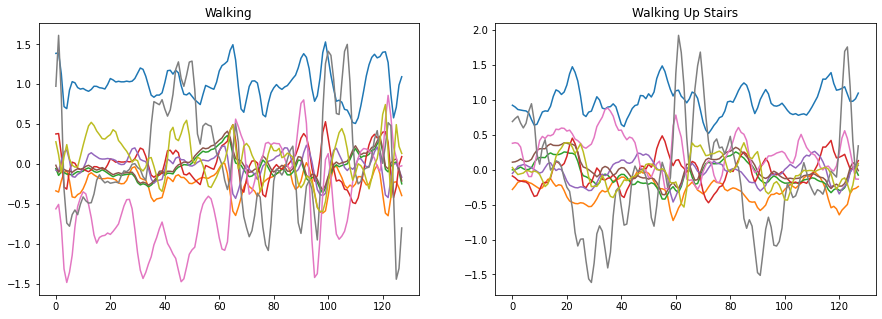

In [11]:
sampleX, sampley = load_dataset_group('train', ds_path + 'HARDataset/')
sampley = sampley.reshape(7352)

#Filter
walking_idx = np.where(sampley == 1)#Walking
walking_up_idx = np.where(sampley== 2)#Walking Up Stairs

walking_vals = sampleX[walking_idx]
walking_up_vals = sampleX[walking_up_idx]

print("Walking:",walking_vals.shape,"\n\nWalking Up Stairs:",walking_up_vals.shape)

fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(walking_vals[0])
ax[1].plot(walking_up_vals[0])
ax[0].set_title("Walking")
ax[1].set_title("Walking Up Stairs")

Sitting: (1286, 128, 9) 

Standing: (1374, 128, 9)


Text(0.5, 1.0, 'Standing')

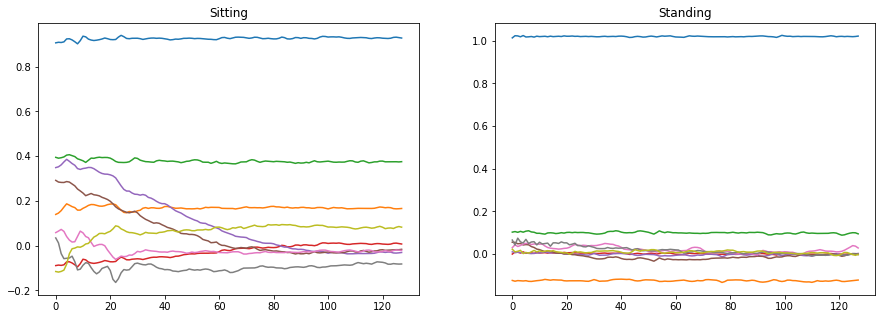

In [12]:
#Filter
sitting_idx = np.where(sampley == 4)#Sitting
standing_idx = np.where(sampley== 5)#Standing

sitting_vals = sampleX[sitting_idx]
standing_vals = sampleX[standing_idx]

print("Sitting:",sitting_vals.shape,"\n\nStanding:",standing_vals.shape)

fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(sitting_vals[0])
ax[1].plot(standing_vals[0])
ax[0].set_title("Sitting")
ax[1].set_title("Standing")

In [13]:
#https://www.kaggle.com/sylvianclee/human-activity-recognition-cnn-lstm
#https://github.com/lokeshkumarn/Notebooks/blob/master/Sample_NB.ipynb
#https://github.com/lokeshkumarn/Notebooks/blob/master/DL_MovieReview_BatchSize.ipynb
#https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/

#### Model 1: Develop an LSTM Network Model

#### Model Building

In [14]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

model  = models.Sequential()

#Sequential Model layers- Use AT LEAST 2 LSTM layers with 80 units with appropriate input for each
model.add(layers.LSTM(80,return_sequences=True, input_shape=(n_timesteps, n_features)))
model.add(layers.LSTM(80))

#Add one layer of dropout at the appropriate position and give reasons
model.add(layers.Dropout(0.5))

#Use AT LEAST 2 dense layers (one with 80 units and one for output) with the appropriate input and output for each.
model.add(layers.Dense(80, activation='relu'))#Choose the appropriate activation function for all the layers.
model.add(layers.Dense(n_outputs, activation='softmax'))#Choose the appropriate activation function for all the layers.

Give reasons for the dropout - Dropout of 0.5 is to drastically reduce the parameters and also generalize better on the unseen data points

In [15]:
#Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128, 80)           28800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 80)                51520     
_________________________________________________________________
dropout (Dropout)            (None, 80)                0         
_________________________________________________________________
dense (Dense)                (None, 80)                6480      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 486       
Total params: 87,286
Trainable params: 87,286
Non-trainable params: 0
_________________________________________________________________


#### Model Compilation

Loss : Categorical Cross Entropy (because it's a multiple classification problem

In [16]:
#Compile the model with the appropriate loss function.
#Use adam optimizer. Give reasons for the choice of learning rate value.
#Use accuracy as a metric.
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,name='Adam'),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Give reasons for the choice of learning rate and its value
Learning rate of 0.001 is choosen, because too high would rollover the minima and I have tried giving the higher learning rate like 0.4, 0.2, 0.1, 0.01 the loss doesn't seem to converge to minima, so decided to lower the learning rate further so that weight update is minimum and proceeds towards the convergence or global minima

#### Model Training

Train the model for an appropriate number of epochs (print the **train and validation accuracy/loss** for
each epoch). Use the batch size of **64**.

In [17]:
# fit network
verbose, epochs, batch_size = 1, 15, 64
start_train = time.time()
history = model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=verbose)
end_train = time.time()

Epoch 1/15
92/92 [==============================] - 11s 26ms/step - loss: 1.3481 - accuracy: 0.4491 - val_loss: 0.9916 - val_accuracy: 0.6125
Epoch 2/15
92/92 [==============================] - 1s 15ms/step - loss: 0.7786 - accuracy: 0.6684 - val_loss: 0.7868 - val_accuracy: 0.7403
Epoch 3/15
92/92 [==============================] - 1s 15ms/step - loss: 0.6008 - accuracy: 0.7440 - val_loss: 0.7455 - val_accuracy: 0.7614
Epoch 4/15
92/92 [==============================] - 1s 15ms/step - loss: 0.5263 - accuracy: 0.7819 - val_loss: 0.6592 - val_accuracy: 0.8131
Epoch 5/15
92/92 [==============================] - 1s 16ms/step - loss: 0.3877 - accuracy: 0.8641 - val_loss: 0.6354 - val_accuracy: 0.8328
Epoch 6/15
92/92 [==============================] - 1s 15ms/step - loss: 0.2607 - accuracy: 0.9154 - val_loss: 0.5626 - val_accuracy: 0.8742
Epoch 7/15
92/92 [==============================] - 1s 15ms/step - loss: 0.1676 - accuracy: 0.9488 - val_loss: 0.5257 - val_accuracy: 0.8946
Epoch 8/15
9

Plot the loss and accuracy history graphs.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


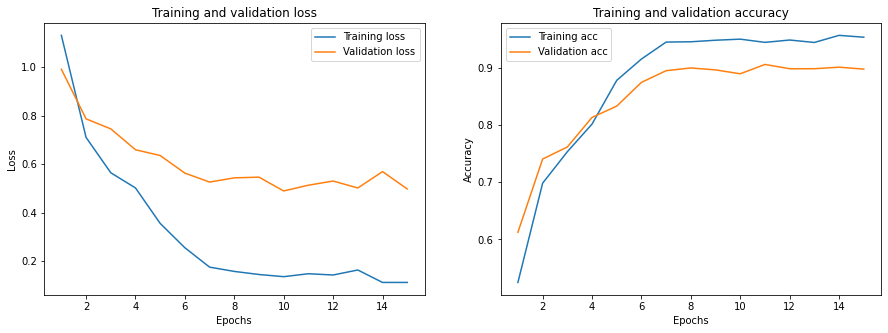

In [18]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fix,ax = plt.subplots(1,2, figsize=(15,5))
ax1 = ax[0] # to plot Training Loss
ax2 = ax[1] # to plot Training Accuracy
ax1.plot(epochs, loss, label='Training loss')
ax1.plot(epochs, val_loss,  label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(epochs, acc, label='Training acc')
ax2.plot(epochs, val_acc,  label='Validation acc')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

Print the total time taken for training.

In [19]:
#Time taken to train
print("Time taken to train the NN:",end_train - start_train," seconds")

Time taken to train the NN: 31.00518822669983  seconds


#### Model Evaluation

Print the final test/validation loss and accuracy.

In [20]:
# evaluate model
results = model.evaluate(testX, testy, batch_size=batch_size, verbose=1)

print("Test Loss:",results[0])
print("Test Accuracy:",results[1])

47/47 [==============================] - 0s 7ms/step - loss: 0.2756 - accuracy: 0.9199
Test Loss: 0.27556926012039185
Test Accuracy: 0.9199185371398926


Print confusion matrix

In [21]:
testX,testy = load_dataset_group("test",ds_path + 'HARDataset/')
y_pred = model.predict(testX).argmax(axis = 1) + 1

df = pd.DataFrame({'y_test':testy.reshape(testy.shape[0]),'y_pred':y_pred})
df.head()
confusion_matrix_result = pd.crosstab(df['y_test'], df['y_pred'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix_result)

Predicted    1    2    3    4    5    6
Actual                                 
1          467   23    6    0    0    0
2           19  451    1    0    0    0
3            2    4  414    0    0    0
4            2   11    2  389   82    5
5           10    0    0   69  453    0
6            0    0    0    0    0  537


In [22]:
confusion_matrix(testy.reshape(testy.shape[0]),y_pred)

array([[467,  23,   6,   0,   0,   0],
       [ 19, 451,   1,   0,   0,   0],
       [  2,   4, 414,   0,   0,   0],
       [  2,  11,   2, 389,  82,   5],
       [ 10,   0,   0,  69, 453,   0],
       [  0,   0,   0,   0,   0, 537]])

In [23]:
print(classification_report(testy.reshape(testy.shape[0]),y_pred))

              precision    recall  f1-score   support

           1       0.93      0.94      0.94       496
           2       0.92      0.96      0.94       471
           3       0.98      0.99      0.98       420
           4       0.85      0.79      0.82       491
           5       0.85      0.85      0.85       532
           6       0.99      1.00      1.00       537

    accuracy                           0.92      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.92      0.92      0.92      2947



#### Model 2: Develop a CNN-LSTM Network Model